# Data cleaning and EDA

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# import data and check everything

df = pd.read_csv('CreditDefault.csv', index_col='ID')
df.head()
df.dtypes
df.shape
df.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [4]:
# rename column for easy reference

df.rename(columns={'default payment next month': 'default'}, inplace=True)
df.columns=df.columns.str.lower()

In [24]:
# check the benchmark

float(df.default.sum())/len(df.default)

0.2212

In [6]:
# by looking at the column names, there might be multicollinearity issues here,
# so check the correlation matrix to confirm

df.corr()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
limit_bal,1.000000,0.024755,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,...,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
sex,0.024755,1.000000,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,-0.055064,...,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961
education,-0.219161,0.014232,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,0.097520,...,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006
marriage,-0.108139,-0.031389,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,0.035629,...,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339
age,0.144713,-0.090874,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,-0.053826,...,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
pay_0,-0.271214,-0.057643,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,0.509426,...,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
pay_2,-0.296382,-0.070771,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,0.622780,...,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551
pay_3,-0.286123,-0.066096,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,0.686775,...,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253
pay_4,-0.267460,-0.060173,0.108793,0.033122,-0.049722,0.538841,0.662067,0.777359,1.000000,0.819835,...,0.245917,0.242902,0.239154,-0.009362,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565,0.216614
pay_5,-0.249411,-0.055064,0.097520,0.035629,-0.053826,0.509426,0.622780,0.686775,0.819835,1.000000,...,0.271915,0.269783,0.262509,-0.006089,-0.003191,0.009062,-0.058299,-0.033337,-0.023027,0.204149


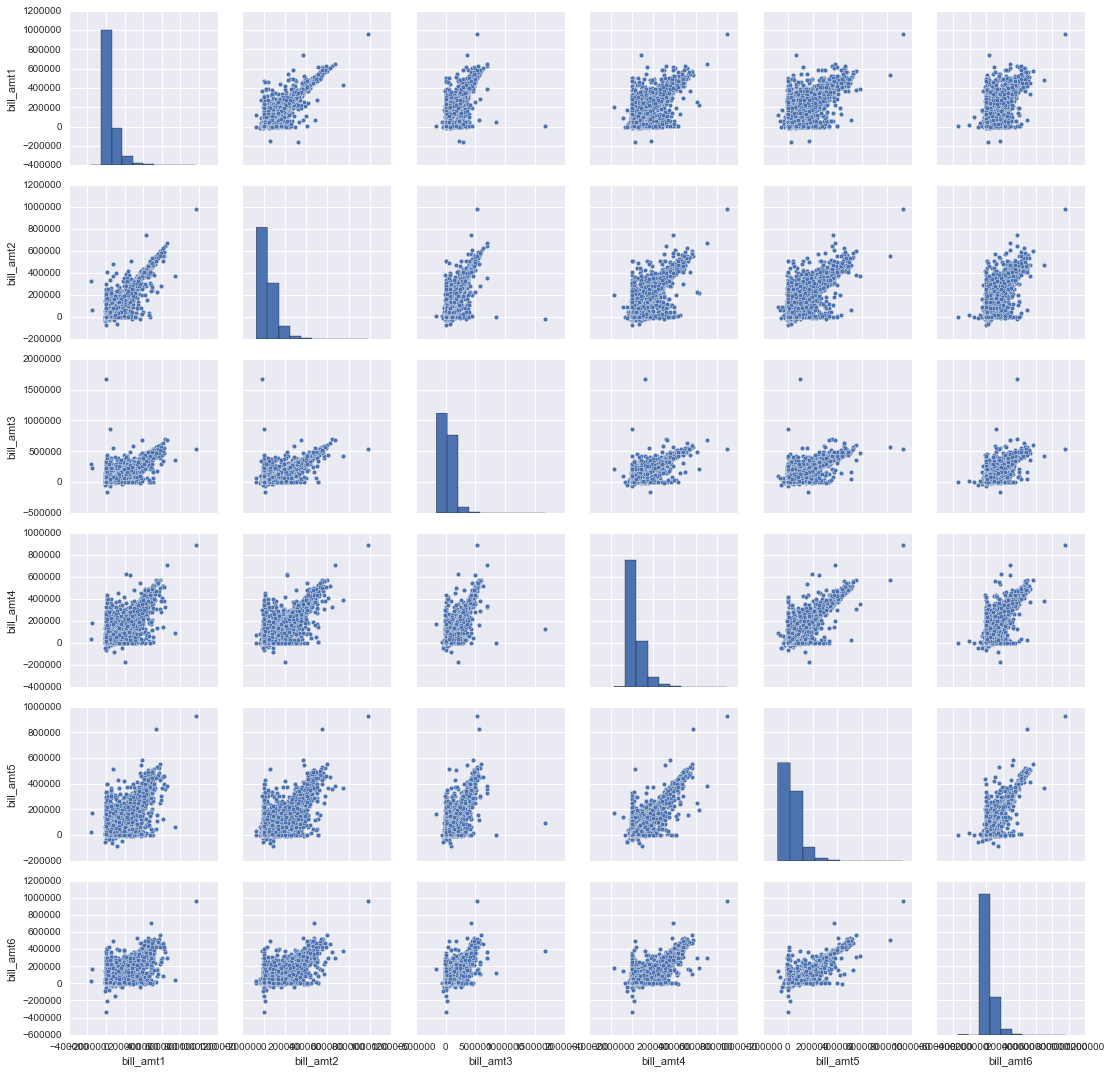

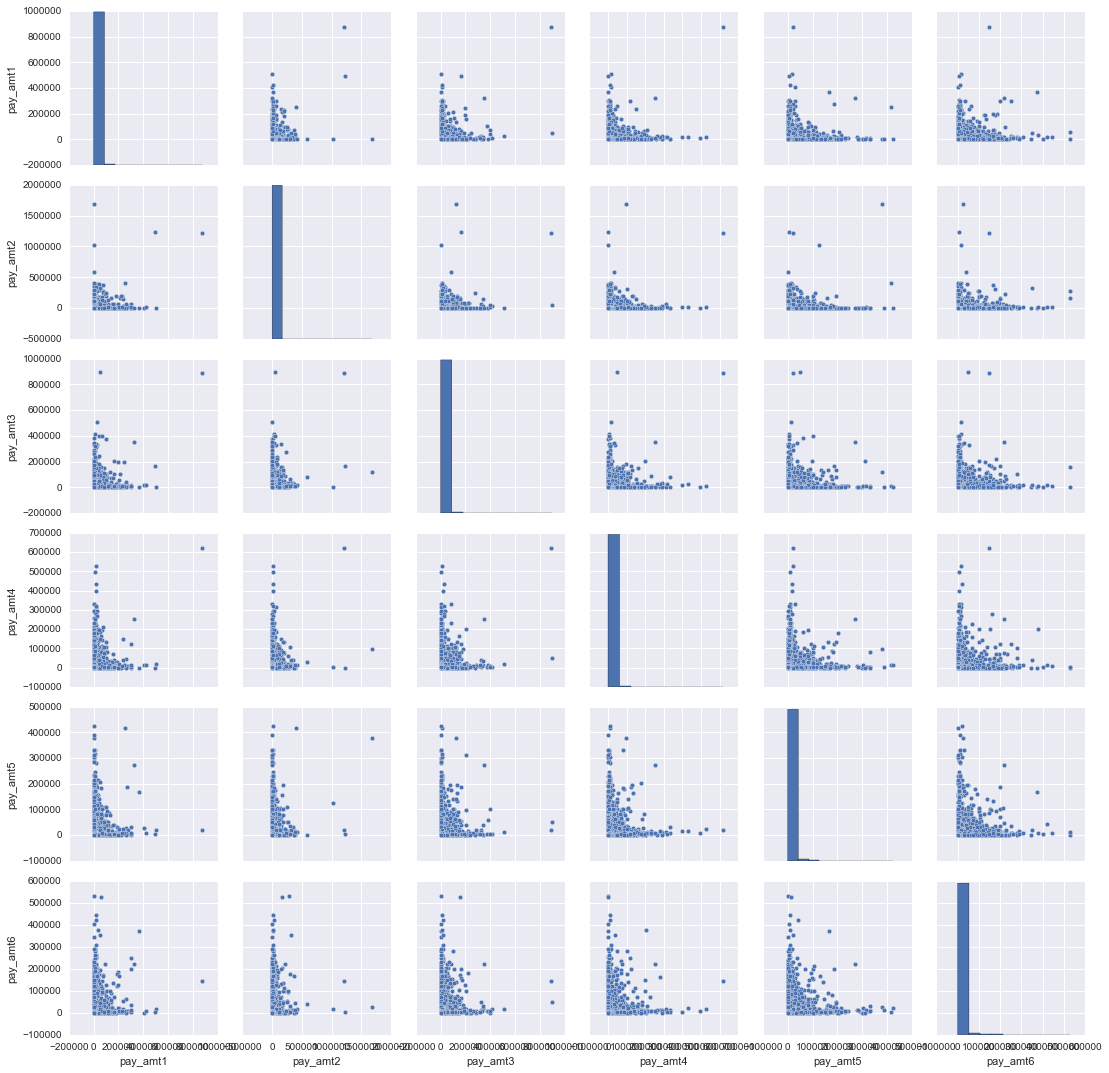

In [7]:
# plot columns with similar names to check the correlation

sns.pairplot(df, vars=df.columns[11:17], kind='scatter')
sns.pairplot(df, vars=df.columns[17:23])

In [8]:
# manually standardize numeric columns

col_to_norm = ['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
              'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

df[col_to_norm]=df[col_to_norm].apply(lambda x: (x-np.mean(x))/np.std(x))

In [9]:
# create dummies for categorical features.
# add 2 to all the values because OneHotEncoder can only handle non-negative values

col_pay = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
df[col_pay] = df[col_pay].apply(lambda x: x+2)

X = df.iloc[:, 0:23]
y = df.default
enc = OneHotEncoder(categorical_features=[1,2,3,5,6,7,8,9,10])
X = enc.fit_transform(X)

In [11]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df.default, random_state=1)

# Define functions to optimize, and evaluate models

In [56]:
# Define function to optimize model based on roc_auc 
# (for unbalanced classes, roc_auc makes more sence since the accuracy score can be fooled by only predicting 0)

def gridsearch(model, params):
    gs = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1)
    gs.fit(X_train, y_train)
    print 'Best params: ', gs.best_params_
    print 'Best auc on training set: ', gs.best_score_
    print 'Best auc on test set: ', gs.score(X_test, y_test)
    return gs.predict(X_test), gs.decision_function(X_test)

In [13]:
# Define function to generate confusion matrix

def plot_confusion(prediction):
    conmat = np.array(confusion_matrix(y_test, prediction, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['default', 'not default'], 
                             columns=['predicted default', 'predicted not default'])
    print confusion

In [57]:
# Define function to plot roc curve

def plot_roc(prob):
    y_score = prob
    fpr = dict()
    tpr = dict()
    roc_auc=dict()
    fpr[1], tpr[1], _ = roc_curve(y_test, y_score)
    roc_auc[1] = auc(fpr[1], tpr[1])

    plt.figure(figsize=[9,7])
    plt.plot(fpr[1], tpr[1], label='Roc curve (area=%0.2f)' %roc_auc[1], linewidth=4)
    plt.plot([1,0], [1,0], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('false positive rate', fontsize=18)
    plt.ylabel('true positive rate', fontsize=18)
    plt.title('ROC curve for credit default', fontsize=18)
    plt.legend(loc='lower right')
    plt.show()

# Stochastic Gradient Descent

In [61]:
# try using stochastic gradient descent with logistic loss function
# specify lasso regularization to select features and address multicollinearity issues

sgd = SGDClassifier(loss='log', penalty='l1', learning_rate='optimal')

# use grid search to optimize parameters
sgd_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0], 'class_weight': [None, 'balanced']}

sgd_pred, sgd_prob = gridsearch(sgd, sgd_params)

Best params:  {'alpha': 0.001, 'class_weight': None}
Best auc on training set:  0.76420955181
Best auc on test set:  0.770418230303


In [62]:
# Check the accuracy score

sgd = SGDClassifier(loss='log', penalty='l1', learning_rate='optimal', alpha=0.001)
print 'accuracy score on training set: ', cross_val_score(sgd, X_train, y_train, n_jobs=-1).mean()
print 'accuracy score on testing set: ', accuracy_score(sgd_pred, y_test)

accuracy score on training set:  0.820904786651
accuracy score on testing set:  0.818777777778


In [63]:
# create classification report
print classification_report(y_test, sgd_pred, target_names=['not default', 'default'])

             precision    recall  f1-score   support

not default       0.84      0.95      0.89      7009
    default       0.66      0.37      0.47      1991

avg / total       0.80      0.82      0.80      9000



In [64]:
# create confusion matrix
plot_confusion(sgd_pred)

             predicted default  predicted not default
default                    731                   1260
not default                371                   6638


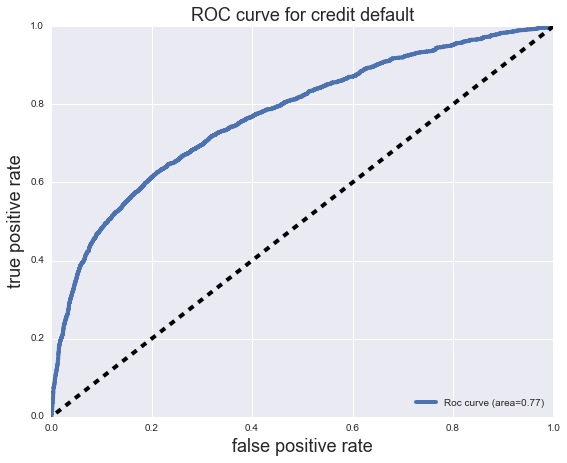

In [65]:
# plot roc curve and calculate auc
plot_roc(sgd_prob)

# Logistic Regression with manual feature selection

In [67]:
# logistic regression with grid search

lr = LogisticRegression(solver='liblinear')
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10], 'class_weight': [None, 'balanced'], 'penalty': ['l1', 'l2']}

lr_pred, lr_prob = gridsearch(lr, lr_params)

Best params:  {'penalty': 'l2', 'C': 0.1, 'class_weight': 'balanced'}
Best auc on training set:  0.767872065391
Best auc on test set:  0.772115982902


In [72]:
# feature selection with the best model from grid search
# roc_auc same as sgdclassifier

lr = LogisticRegression(penalty='l2', C=0.1, solver='liblinear', class_weight='balanced')
rfecv = RFECV(estimator=lr, scoring='roc_auc')
model = rfecv.fit(X_train, y_train)
lr_pred = model.predict(X_test)
lr_prob = model.decision_function(X_test)
print 'Test score: ', model.score(X_test, y_test)

Test score:  0.773888888889


In [76]:
# Check the accuracy score, much worse than sgdclassifier

print 'accuracy score on training set: ', cross_val_score(lr, X_train, y_train, n_jobs=-1).mean()
print 'accuracy score on testing set: ', accuracy_score(lr_pred, y_test)

accuracy score on training set:  0.777333452746
accuracy score on testing set:  0.773888888889


In [74]:
# print confusion matrix
# the model catches more default, but made more mistake in identifying non default at the same time
# So if the bank cares more about identifying people who are going to default (more conservative), 
# this model may be a better choice. If the bank is more aggressive, go for the first one.
plot_confusion(lr_pred)

             predicted default  predicted not default
default                   1138                    853
not default               1182                   5827


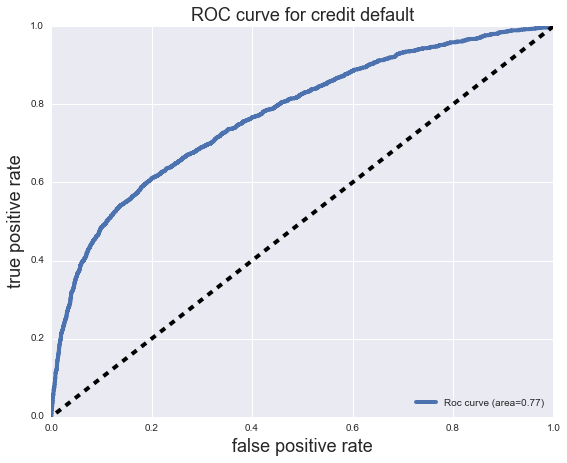

In [75]:
# plot roc curve

plot_roc(lr_prob)